In [1]:
#get aws keys
import csv
with open('private/accessKeys.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for line in readCSV:
        access_key = line[0]
        secret_key = line[1]

In [2]:
#use pyathenajdbc to query an athena table
from pyathenajdbc import connect
import pandas as pd
import numpy as np
connection = connect(access_key=access_key, secret_key=secret_key, s3_staging_dir='s3://spark-one-off/pyathena/',
    region_name='us-west-2')

In [3]:
#read train table into dataframe...is slow, likely due to pyathenajdbc
query = 'select * from oneoff.train'
train = pd.read_sql(query, connection)
print train.dtypes
train.head(5)

id           int64
ran_num    float64
class       object
xscore     float64
oscore     float64
bscore     float64
x0         float64
y0         float64
x          float64
y          float64
dtype: object


,id,ran_num,class,xscore,oscore,bscore,x0,y0,x,y
0,0,0.501556,B,0.0,0.0,1.0,-5.340845,3.594962,-4.599729,3.063883
1,1,0.575203,B,0.0,0.0,1.0,1.711209,6.372452,1.624187,6.282235
2,2,0.651700,X,1.0,0.0,0.0,-3.712934,3.939977,-3.165454,3.707388
3,3,0.957303,B,0.0,0.0,1.0,-0.944174,5.578075,-1.519768,4.714392
4,4,0.816188,B,0.0,0.0,1.0,-5.380518,3.513846,-5.070162,3.440407


In [4]:
#get indices of X, O and B classes
print 'number of records in train = ', len(train)
idx_x = train['class'] == 'X'
idx_o = train['class'] == 'O'
idx_b = train['class'] == 'B'
print 'X fraction = ', idx_x.sum()*1.0/len(idx_x)
print 'O fraction = ', idx_o.sum()*1.0/len(idx_o)
print 'B fraction = ', idx_b.sum()*1.0/len(idx_b)
print 'B/O ratio = ', idx_b.sum()*1.0/idx_o.sum()

number of records in train =  10000
X fraction =  0.1333
O fraction =  0.1292
B fraction =  0.7375
B/O ratio =  5.70820433437


In [5]:
#prep plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2, font='DejaVu Sans')

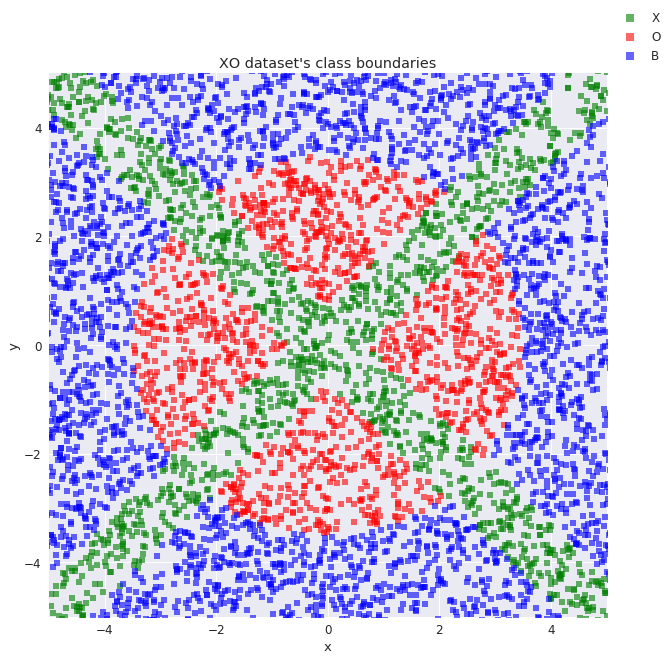

In [6]:
#scatterplot of jitterless (x0,y0) data, to show actual decision boundaries
f, ax = plt.subplots(figsize=(10, 10))
df = train
clr = 'green'
idx = idx_x
xp = df['x0'][idx]
yp = df['y0'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = idx_o
xp = df['x0'][idx]
yp = df['y0'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = idx_b
xp = df['x0'][idx]
yp = df['y0'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("XO dataset's class boundaries")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)

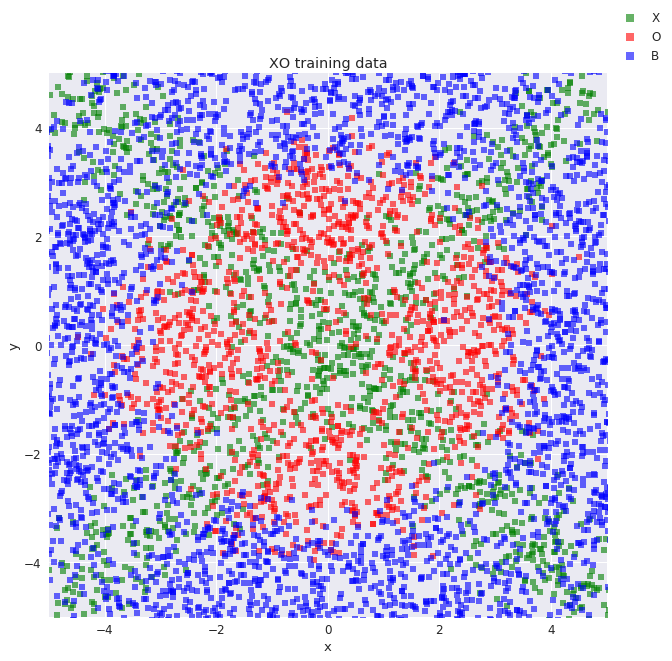

In [7]:
#scatterplot of training (x,y) data
f, ax = plt.subplots(figsize=(10, 10))
df = train
clr = 'green'
idx = idx_x
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = idx_o
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = idx_b
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title('XO training data')
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)

In [8]:
#get the number of different hidden layers
pd.read_sql('select distinct(N_hidden) as N from oneoff.grid order by N', connection)

,N
0,7
1,10
2,20
3,40
4,60
5,80
6,100
7,150
8,200
9,400


x             float64
y             float64
class_pred     object
n_hidden        int64
dtype: object
number of records in grid =  10201
     x    y class_pred  n_hidden
0 -5.0 -5.0          X         7
1 -4.9 -5.0          X         7
2 -4.8 -5.0          X         7
3 -4.7 -5.0          X         7
4 -4.6 -5.0          X         7


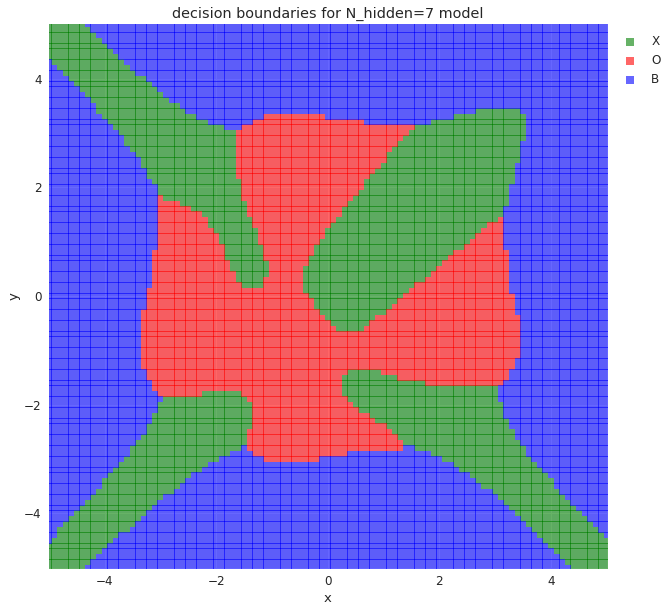

In [9]:
#decision surface for MLP model having N_hidden=7
query = 'select * from oneoff.grid where (N_hidden=7)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=7 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid7 = grid

x             float64
y             float64
class_pred     object
n_hidden        int64
dtype: object
number of records in grid =  10201
     x    y class_pred  n_hidden
0 -5.0 -5.0          X        10
1 -4.9 -5.0          X        10
2 -4.8 -5.0          X        10
3 -4.7 -5.0          X        10
4 -4.6 -5.0          B        10


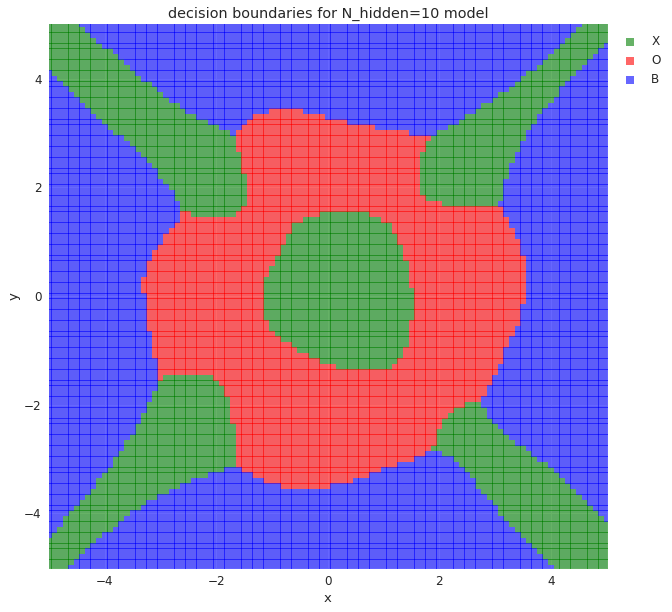

In [10]:
#decision surface for MLP model having N_hidden=10
query = 'select * from oneoff.grid where (N_hidden=10)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=10 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid10 = grid

x             float64
y             float64
class_pred     object
n_hidden        int64
dtype: object
number of records in grid =  10201
     x    y class_pred  n_hidden
0 -5.0 -5.0          X        20
1 -4.9 -5.0          X        20
2 -4.8 -5.0          X        20
3 -4.7 -5.0          X        20
4 -4.6 -5.0          X        20


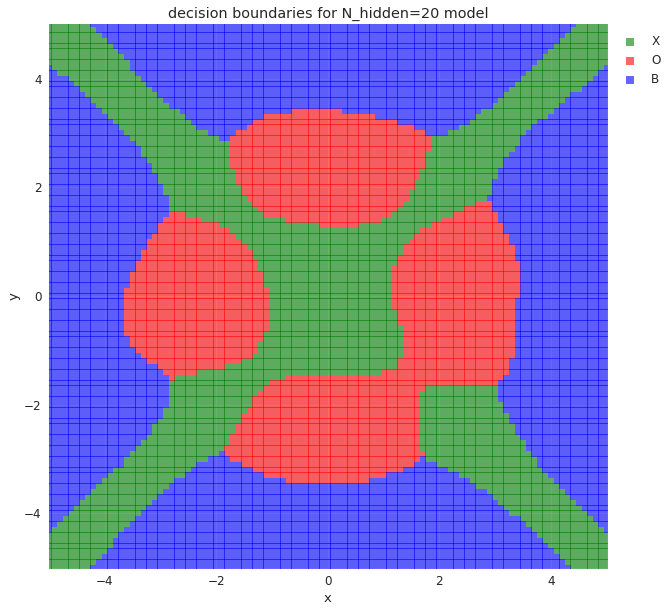

In [11]:
#decision surface for MLP model having N_hidden=20
query = 'select * from oneoff.grid where (N_hidden=20)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=20 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid20 = grid

x             float64
y             float64
class_pred     object
n_hidden        int64
dtype: object
number of records in grid =  10201
     x    y class_pred  n_hidden
0 -5.0 -5.0          X        40
1 -4.9 -5.0          X        40
2 -4.8 -5.0          X        40
3 -4.7 -5.0          X        40
4 -4.6 -5.0          X        40


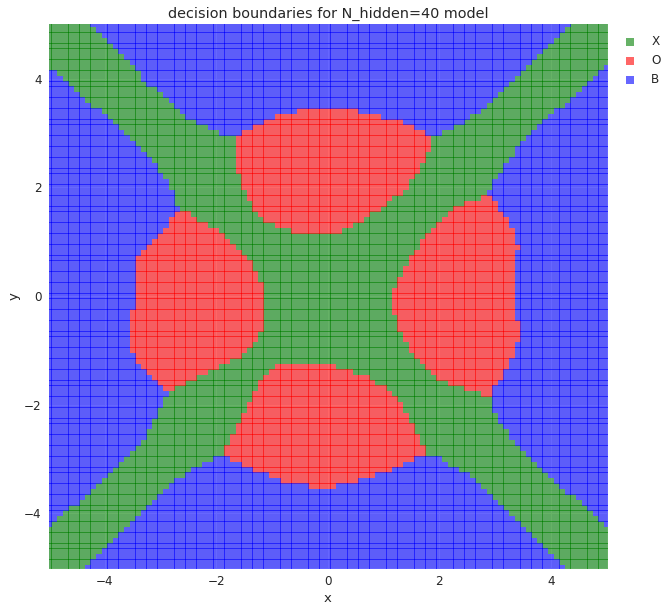

In [12]:
#decision surface for MLP model having N_hidden=50
query = 'select * from oneoff.grid where (N_hidden=50)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=50 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid50 = grid

x             float64
y             float64
class_pred     object
n_hidden        int64
dtype: object
number of records in grid =  10201
     x    y class_pred  n_hidden
0 -5.0 -5.0          X       100
1 -4.9 -5.0          X       100
2 -4.8 -5.0          X       100
3 -4.7 -5.0          X       100
4 -4.6 -5.0          X       100


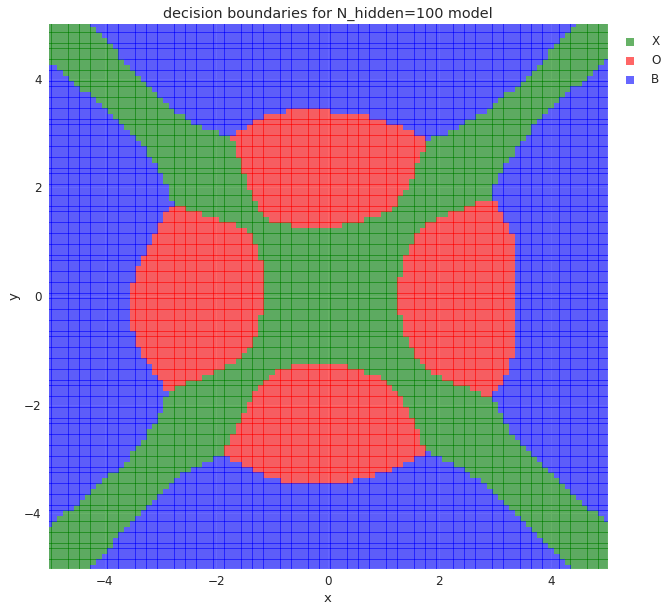

In [15]:
#decision surface for MLP model having N_hidden=100
query = 'select * from oneoff.grid where (N_hidden=100)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=100 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid100 = grid

x             float64
y             float64
class_pred     object
n_hidden        int64
dtype: object
number of records in grid =  10201
     x    y class_pred  n_hidden
0 -5.0 -5.0          X       150
1 -4.9 -5.0          X       150
2 -4.8 -5.0          X       150
3 -4.7 -5.0          X       150
4 -4.6 -5.0          X       150


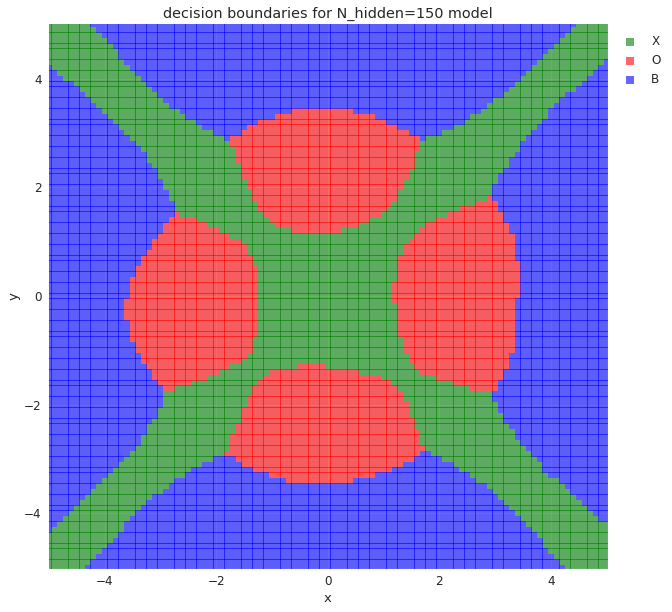

In [16]:
#decision surface for MLP model having N_hidden=150
query = 'select * from oneoff.grid where (N_hidden=150)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=150 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid150 = grid

x             float64
y             float64
class_pred     object
n_hidden        int64
dtype: object
number of records in grid =  10201
     x    y class_pred  n_hidden
0 -2.0 -4.4          B       200
1 -1.9 -4.4          B       200
2 -1.8 -4.4          B       200
3 -1.7 -4.4          B       200
4 -1.6 -4.4          B       200


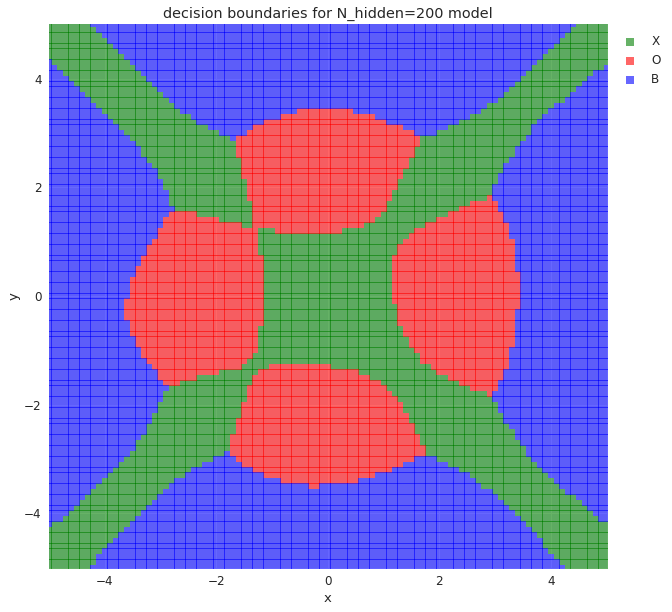

In [17]:
#decision surface for MLP model having N_hidden=200
query = 'select * from oneoff.grid where (N_hidden=200)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=200 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid200 = grid

x             float64
y             float64
class_pred     object
n_hidden        int64
dtype: object
number of records in grid =  10201
     x    y class_pred  n_hidden
0 -5.0 -5.0          X       400
1 -4.9 -5.0          X       400
2 -4.8 -5.0          X       400
3 -4.7 -5.0          X       400
4 -4.6 -5.0          X       400


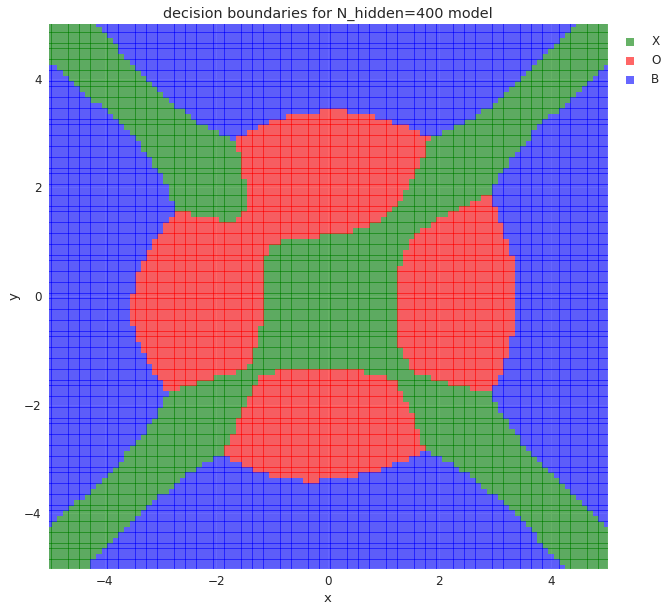

In [18]:
#decision surface for MLP model having N_hidden=400
query = 'select * from oneoff.grid where (N_hidden=400)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=400 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid400 = grid

x             object
y             object
class_pred    object
n_hidden      object
dtype: object
number of records in grid =  0
Empty DataFrame
Columns: [x, y, class_pred, n_hidden]
Index: []


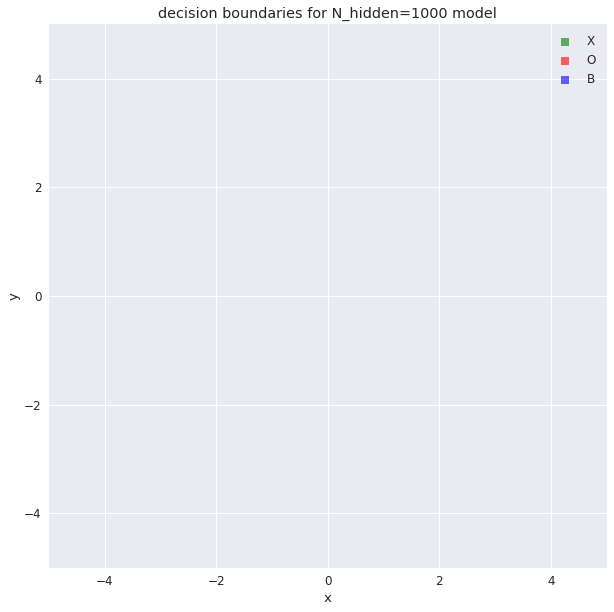

In [19]:
#decision surface for MLP model having N_hidden=700
query = 'select * from oneoff.grid where (N_hidden=700)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=700 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid700 = grid

In [ ]:
#decision surface for MLP model having N_hidden=1000
query = 'select * from oneoff.grid where (N_hidden=1000)'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("decision boundaries for N_hidden=1000 model")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)
grid1000 = grid